# Homework 6
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and HAC methods for clustering and image segmentation.

In [3]:
# Setup
from __future__ import print_function
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

## 1 Clustering Algorithms (40 points)

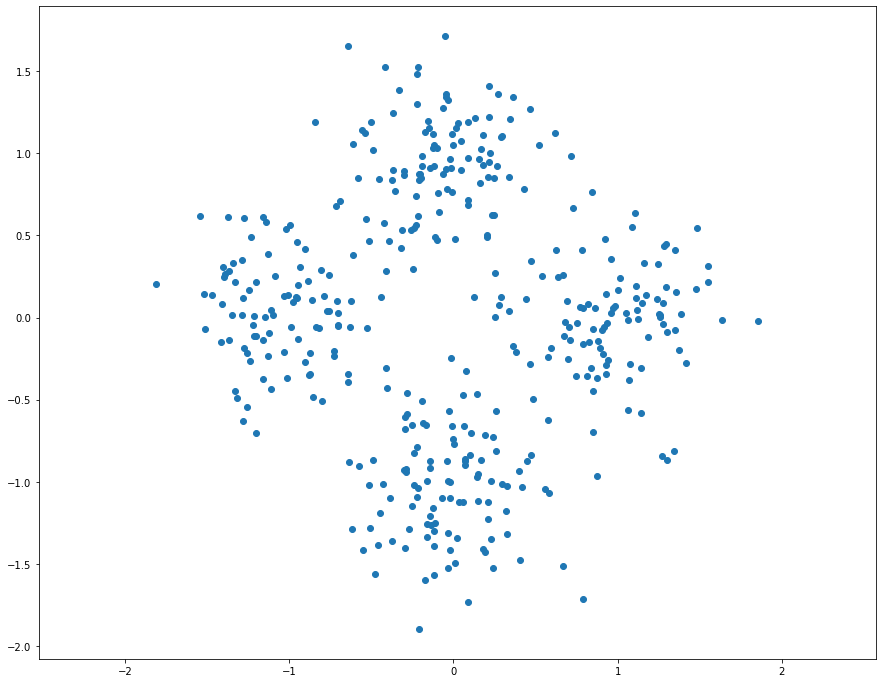

In [3]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (20 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute a new mean for each cluster.

kmeans running time: 0.065336 seconds.


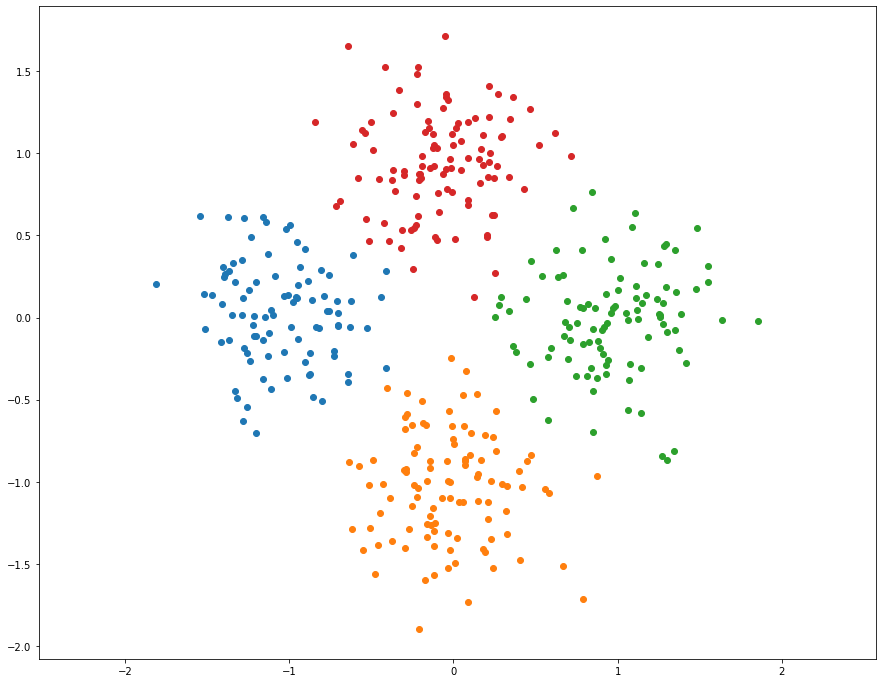

In [18]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

We can use numpy functions and broadcasting to make K-Means faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation.

kmeans running time: 0.001005 seconds.
64.999526 times faster!


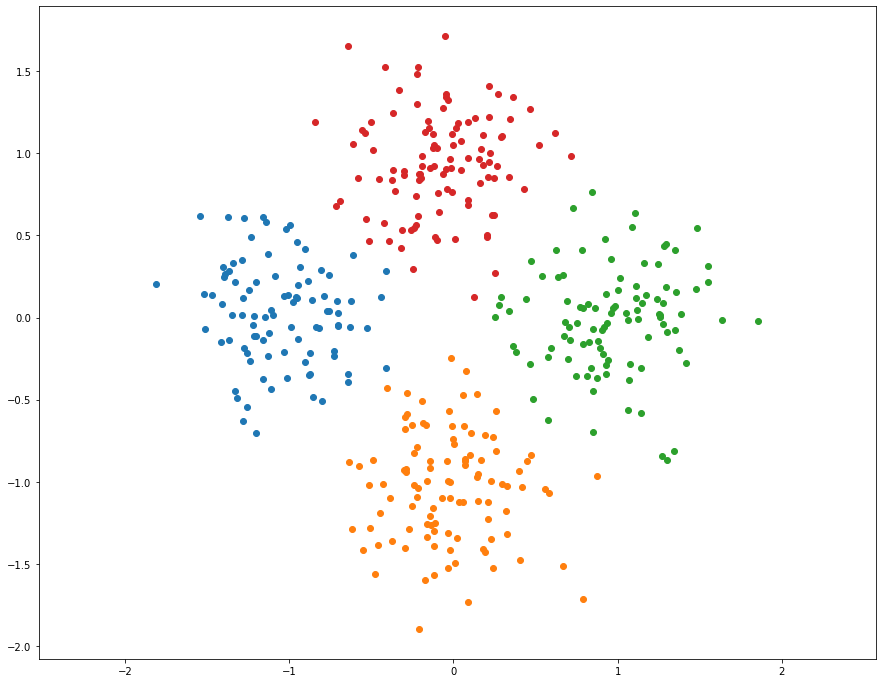

In [20]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 K-Means Convergence (10 points)
Implementations of the K-Means algorithm will often have the parameter `num_iters` to define the maximum number of iterations the algorithm should run for. Consider that we opt to not include this upper bound on the number of iterations, and that we define the termination criterion of the algorithm to be when the cost $L$ stops changing.

Recall that $L$ is defined as the sum of squared distance between all points $x$ and their nearest cluster center $c$:

$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$

Show that for any set of points **$D$** and any number of clusters $k$, the K-Means algorithm will terminate in a finite number of iterations.

**Answer:**<br>
Since $D$ and $k$ are finite and K-Means is a converging algorithm, it is gauranteed that $L$ will decrease at each iteration. In this finite state space, with finite $D$ and $k$, $L$ will eventually reach a local minimum after a finite number of iterations. Therefore, for any set of points $D$ and any number of clusters $k$, the K-Means algorithm will terminate in a finite number of iterations.

### 1.2 Hierarchical Agglomerative Clustering (10 points)
Another simple clustering algorithm is Hieararchical Agglomerative Clustering, which is somtimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters (see Algorithm 1).

Implement **`hiererachical_clustering`** in `segmentation.py`.

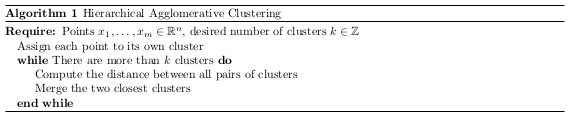

hierarchical_clustering running time: 0.130810 seconds.


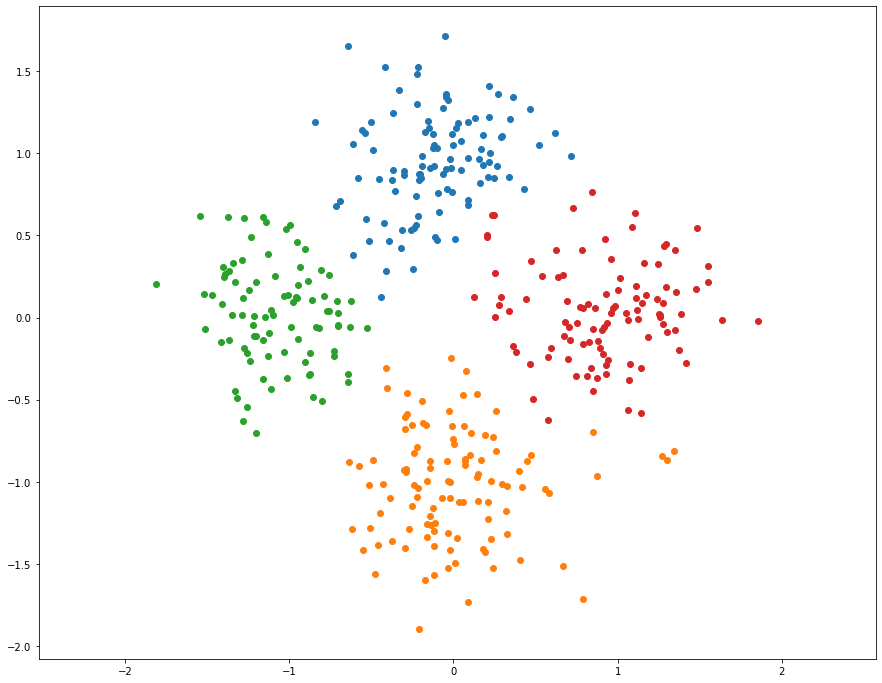

In [24]:
from segmentation import hierarchical_clustering

start = time()
assignments = hierarchical_clustering(X, 4)
end = time()

print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

## 2 Pixel-Level Features (30 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vector* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

(399, 624, 3)


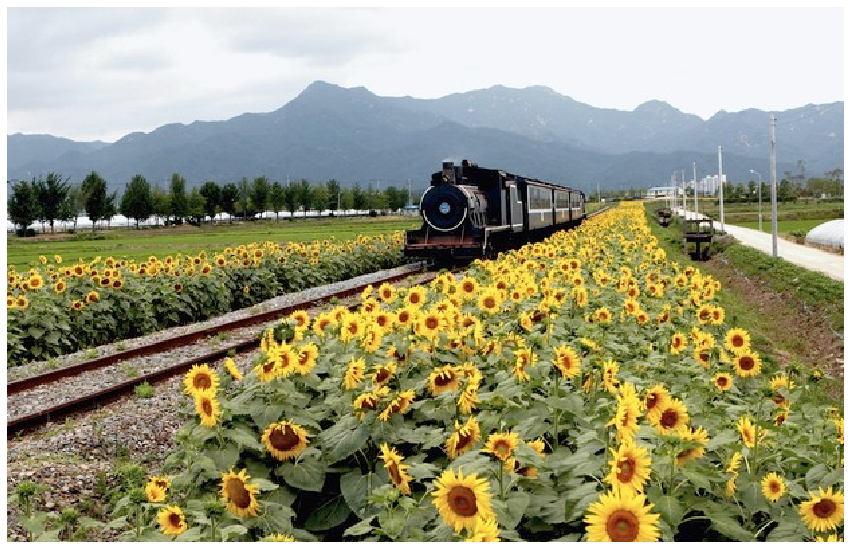

In [141]:
# Load and display image
img = io.imread('train.jpg')
H, W, C = img.shape
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
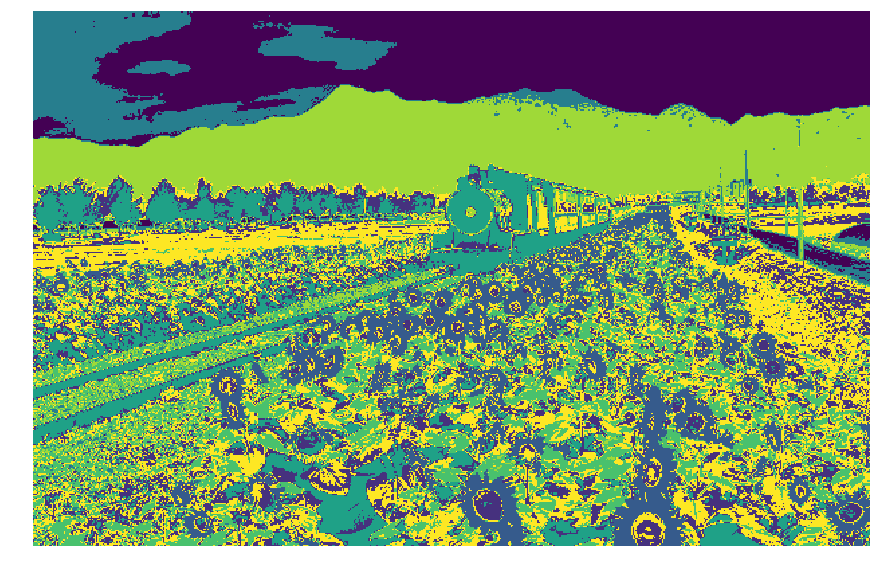

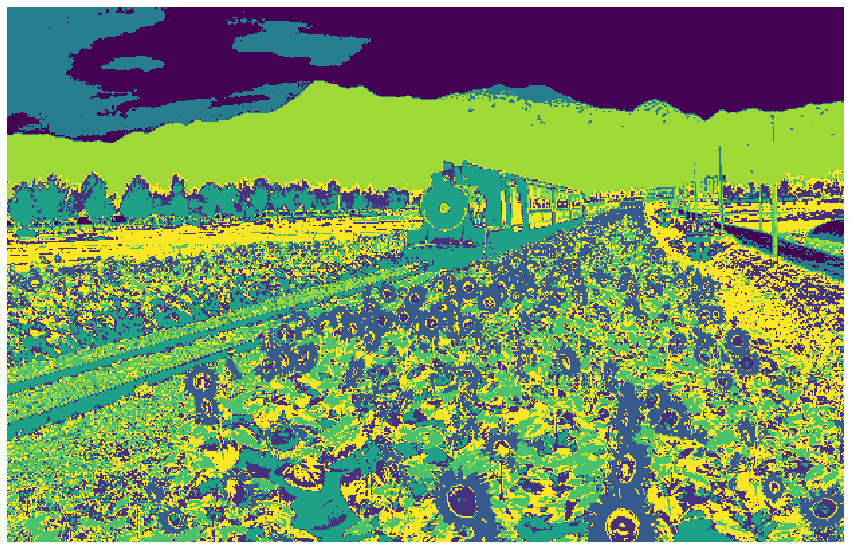

In [26]:
from segmentation import color_features
np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

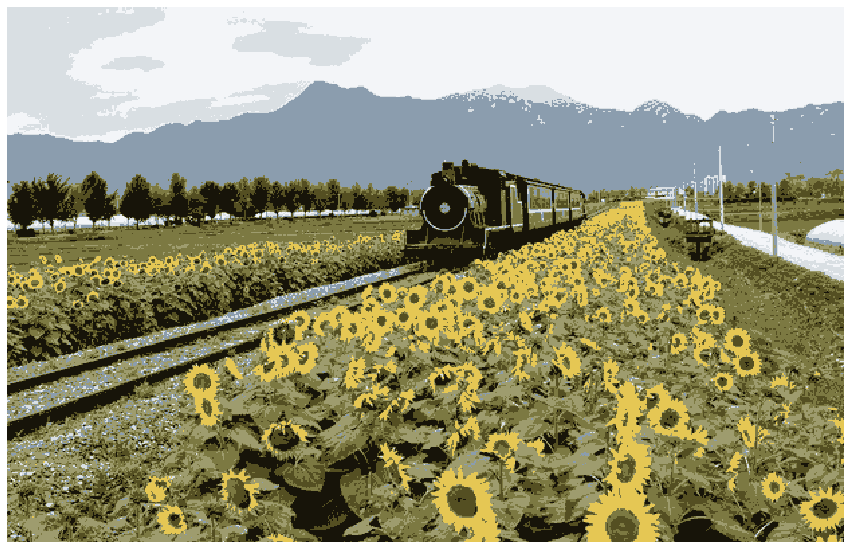

In [27]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (15 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
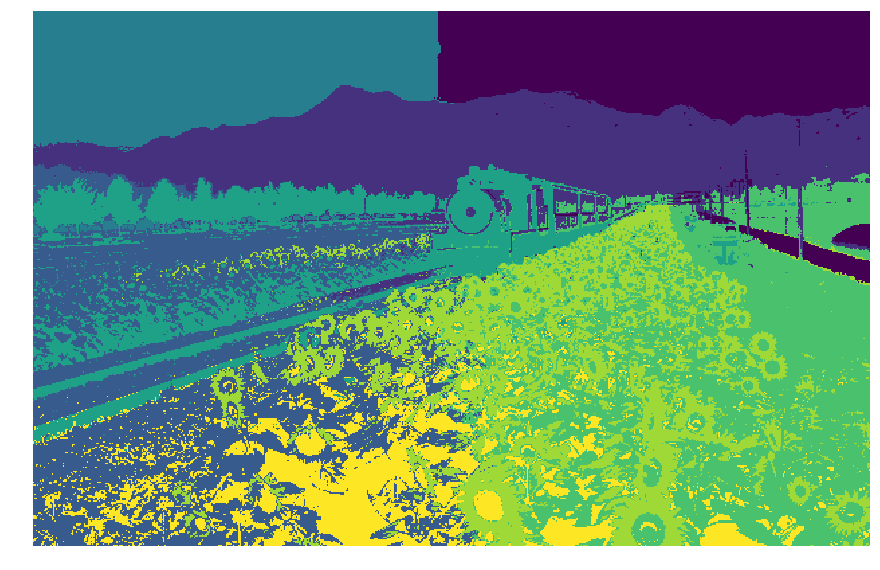

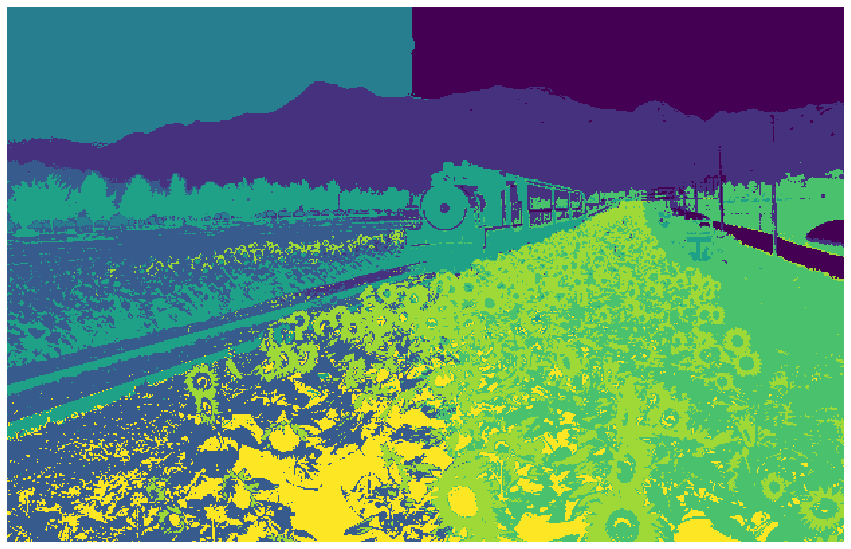

In [29]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

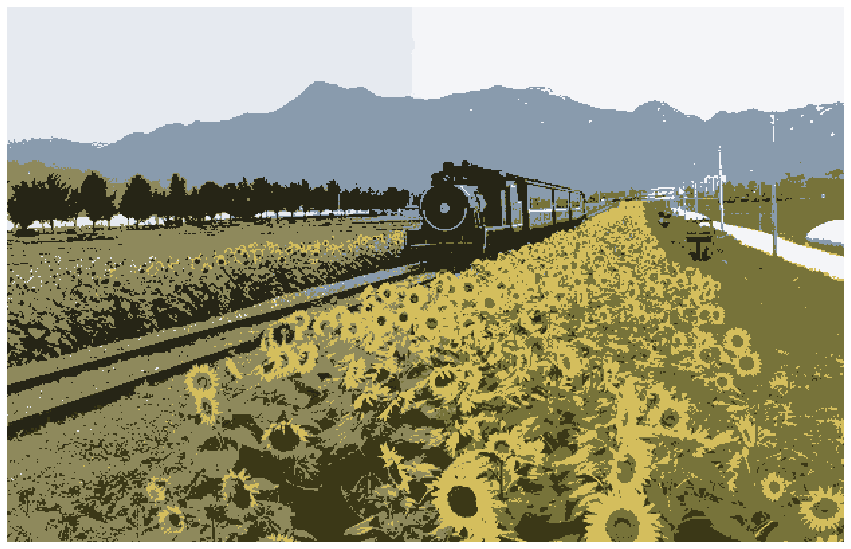

In [30]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit (up to 1% of final grade).

**Describe my approach**:<br>
My approach concatenate each pixel's average color and position. For example, for a pixel of color $(r,g,b)$ located at position $(x,y)$  in the image, its feature vector would be $(m,x,y)$, for which m is the average of r, g, and b. To correct for uneven scaling between different features, I force each feature to have zero mean and unit variance.

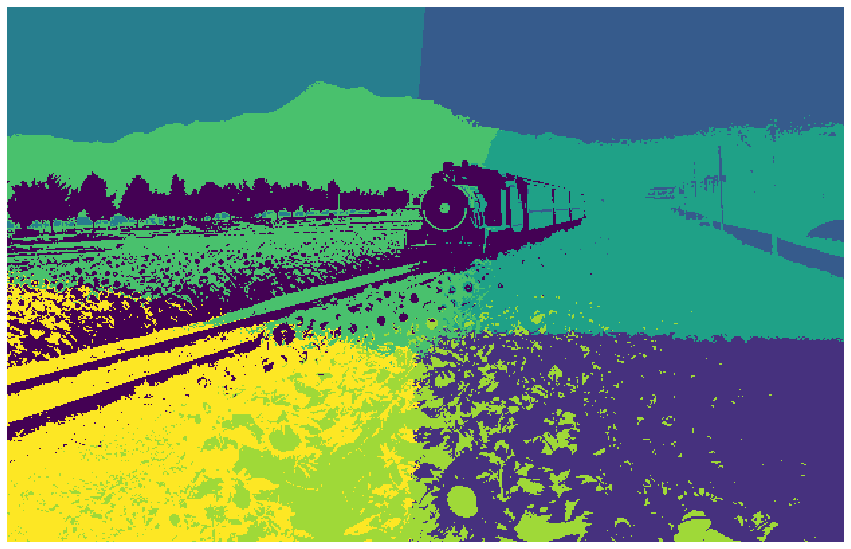

In [33]:
from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

## 3 Quantitative Evaluation (30 points)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this project we have supplied a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering methods) on this dataset.

We can cast the segmentation task into a binary classification problem, where we need to classify each pixel in an image into either foreground (positive) or background (negative). Given the ground-truth labels, the accuracy of a segmentation is $(TP+TN)/(P+N)$.

Implement **`compute_accuracy`** in `segmentation.py`.

Accuracy: 0.97


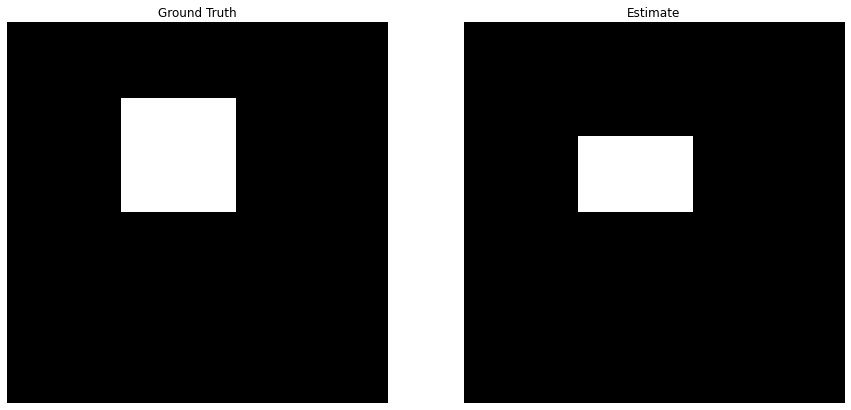

In [41]:
from segmentation import compute_accuracy

mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

In [54]:
from utils import load_dataset, compute_segmentation
from segmentation import evaluate_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation.
num_segments = 2
clustering_fn = kmeans_fast
feature_fn = color_features
scale = 0.6

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

Accuracy for image 0: 0.8341
Accuracy for image 1: 0.9282
Accuracy for image 2: 0.9836
Accuracy for image 3: 0.5512
Accuracy for image 4: 0.7003
Accuracy for image 5: 0.8639
Accuracy for image 6: 0.5654
Accuracy for image 7: 0.8760
Accuracy for image 8: 0.9044
Accuracy for image 9: 0.9403
Accuracy for image 10: 0.8437
Accuracy for image 11: 0.5851
Accuracy for image 12: 0.7000
Accuracy for image 13: 0.6445
Accuracy for image 14: 0.7750
Accuracy for image 15: 0.5019
Mean accuracy: 0.7623


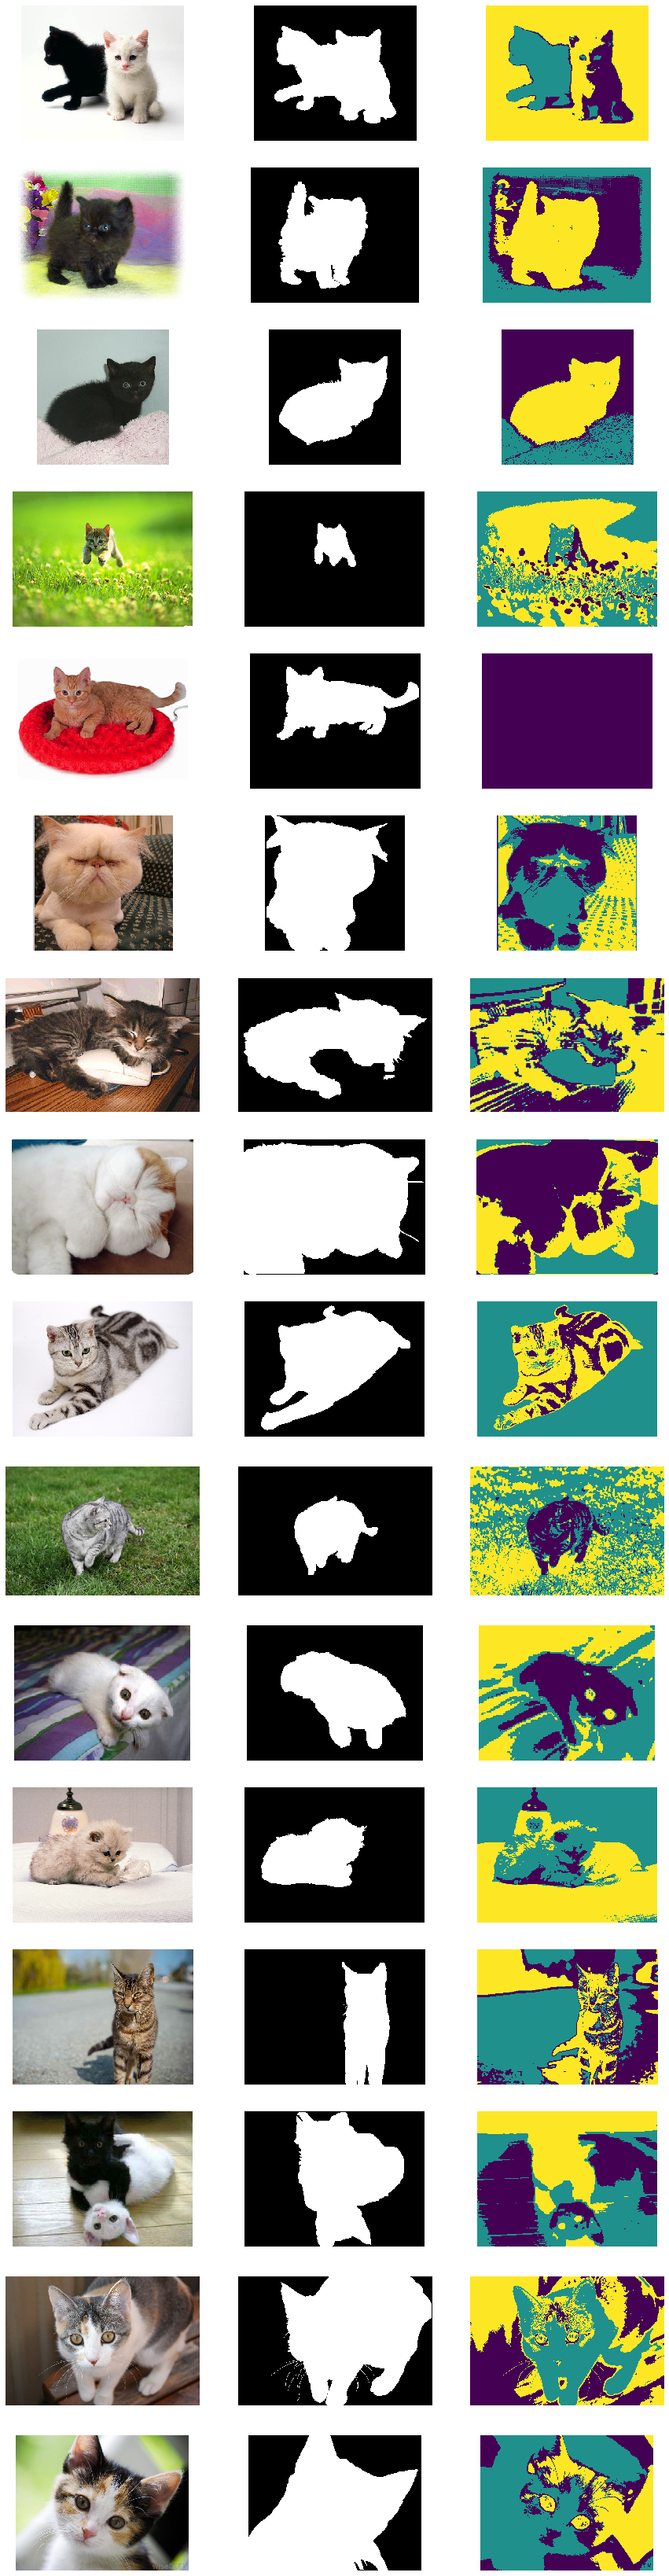

In [38]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 6 combinations of parameters. To present your results, add rows to the table below (you may delete the first row).

**One tip from us** is that it's okay to avoid using hierarchical clustering altogether. The HAC algorithm is quite slow for larger scales. It is totally fine to just K-Means and modulate the other parameters of the clustering function!

 <table style="width:100%">
  <tr>
    <th>Feature Transform</th>
    <th>Clustering Method</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7972</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.5</td>
    <td>0.7632</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.6</td>
    <td>0.7623</td>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.4</td>
    <td>0.7602</td>
  </tr>
  <tr>
    <td>Color Position</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.7680</td>
  </tr>
  <tr>
    <td>Color Position</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.5</td>
    <td>0.7559</td>
  </tr>
  <tr>
    <td>Color Position</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.6</td>
    <td>0.7228</td>
  </tr>
  <tr>
    <td>Color Position</td>
    <td>K-Means</td>
    <td>2</td>
    <td>0.4</td>
    <td>0.6620</td>
  </tr>
</table> 

Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

**Answer**:<br>
1. Color feature performs better than color-position feature. Higher number of segments can increase the quality. Tunning scale doesn't seem to help.
2. There are some images more difficult to segment correctly such as image 15. These images typically has various colors which makes the segmentation difficult.

## 4 Mean-Shift Clustering
Mean-shift clustering is another clustering algorithm which is widely used. Unlike K-Means cluster, mean-shift does not require specifying the number of clusters in advance. The number of clusters is determined by the algorithm with respect to the data. Its algorithm is an iterative mode search. There are basically four main steps:
1. Initialize the random seed and window W
2. Calculate the center of gravity (mean) of W: $$\sum_{x\in W}xH(x)$$
3. Shift the search window to the mean
4. Repeat step 2 until convergence

### 4.1 Use Sklearn
Sklearn contains a build-in mean-shift algorithm. Let's implement it below.

In [4]:
from sklearn.cluster import MeanShift

Mean-shift running time: 0.885643 seconds.


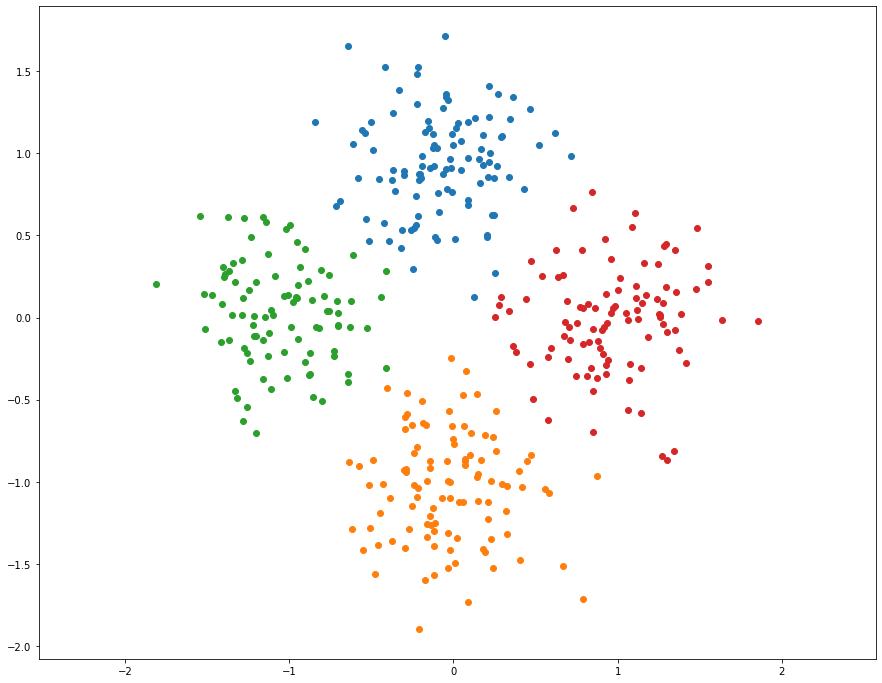

In [29]:
np.random.seed(0)
start = time()
clustering = MeanShift(bandwidth=0.5).fit(X)
assignments = clustering.labels_
end = time()

#print(assignments)

mean_shift_runtime = end - start
print("Mean-shift running time: %f seconds." % mean_shift_runtime)

for i in range(np.max(assignments)+1):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])
plt.axis('equal')
plt.show()

### 4.2 Implement My Own Mean-shift
In this section, I'll implement my own mean-shift algorithm.

Mean-shift running time: 5.175090 seconds.


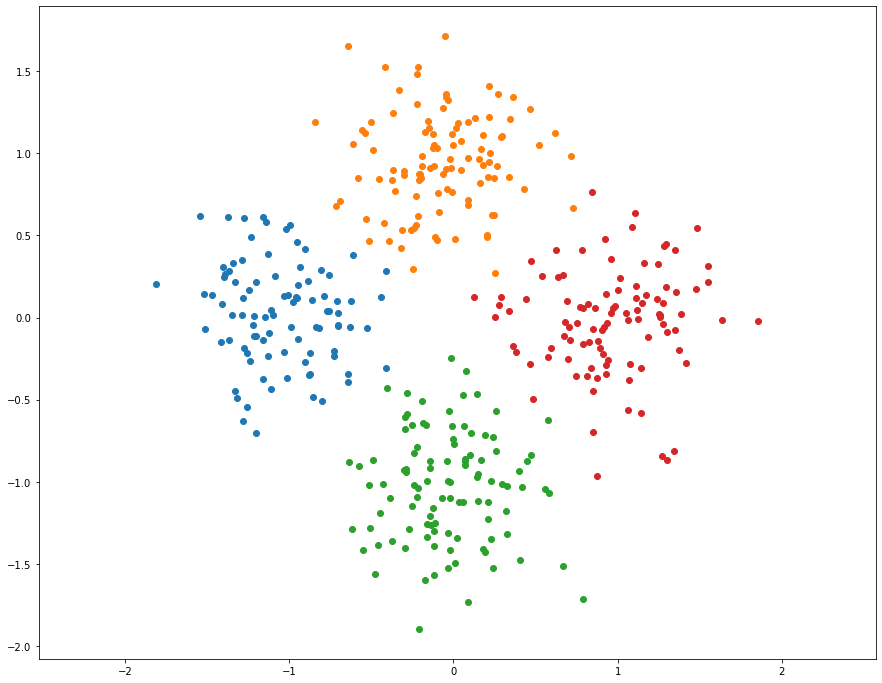

In [82]:
from mean_shift import Mean_Shift as ms

np.random.seed(0)
start = time()
mean_shifter = ms(radius=0.5)
_, assignments = mean_shifter.fit(X)
end = time()

#assignments = np.array(assignments)
#print(assignments)

mean_shift_runtime = end - start
print("Mean-shift running time: %f seconds." % mean_shift_runtime)

for i in range(np.max(assignments)+1):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])
plt.axis('equal')
plt.show()

### 4.3 Pros: No need to specifiy the number of clusters

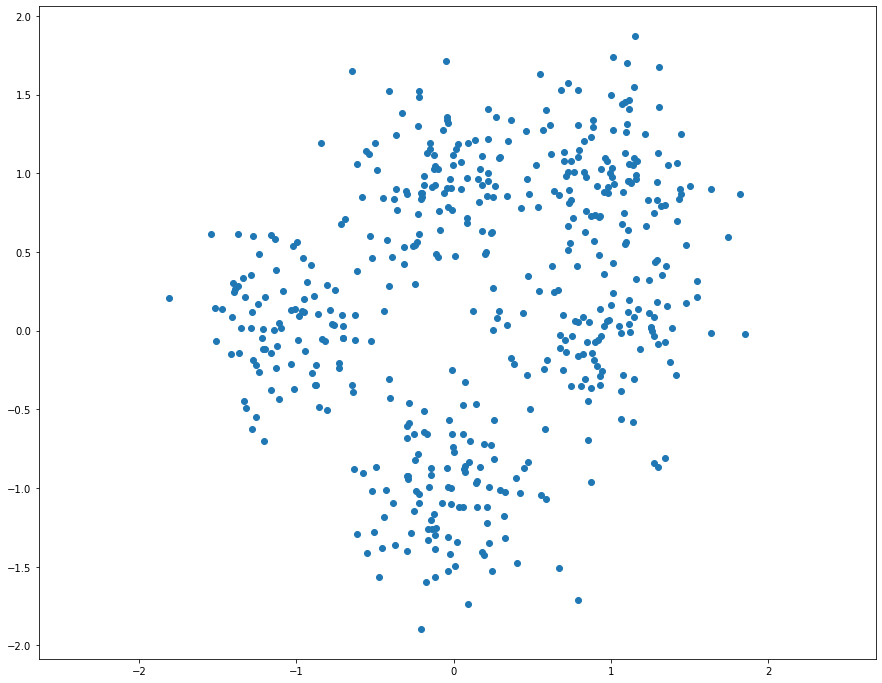

In [83]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Cluster 5
mean5 = [1, 1]
cov5 = [[0.1, 0], [0, 0.1]]
X5 = np.random.multivariate_normal(mean5, cov5, 100)

# Merge two sets of data points
X1 = np.concatenate((X1, X2, X3, X4, X5))

# Plot data points
plt.scatter(X1[:, 0], X1[:, 1])
plt.axis('equal')
plt.show()

Mean-shift running time: 8.827748 seconds.


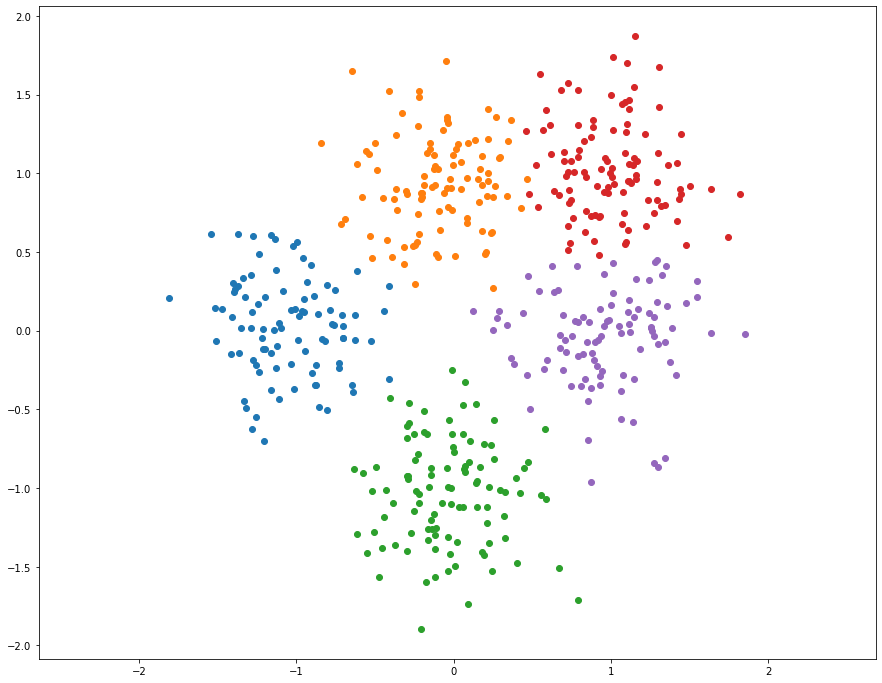

In [84]:
start = time()
mean_shifter = ms(radius=0.5)
_, assignments = mean_shifter.fit(X1)
end = time()

#assignments = np.array(assignments)
#print(assignments)

mean_shift_runtime = end - start
print("Mean-shift running time: %f seconds." % mean_shift_runtime)

for i in range(np.max(assignments)+1):
    cluster_i = X1[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])
plt.axis('equal')
plt.show()

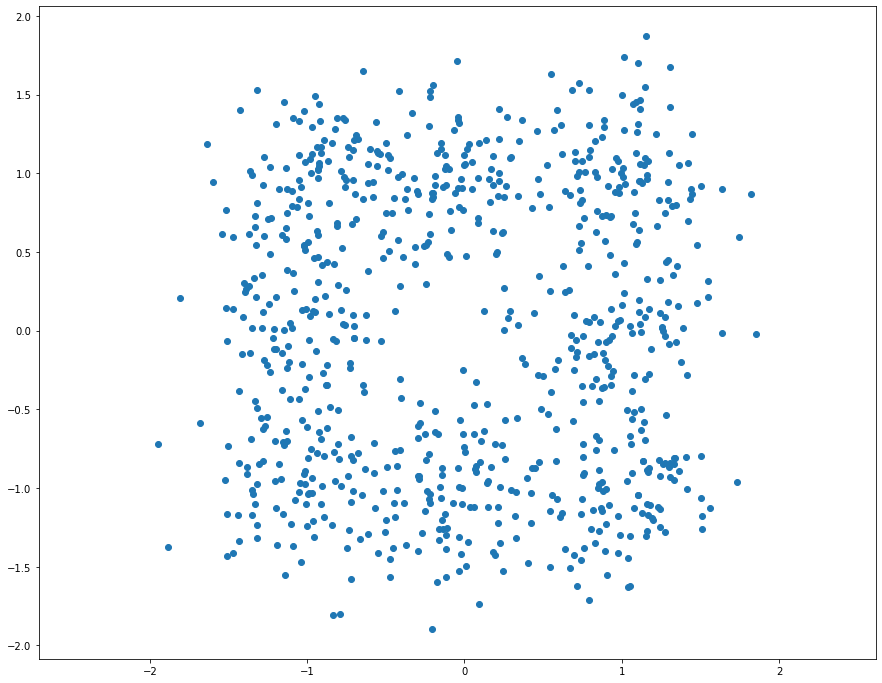

In [136]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Cluster 5
mean5 = [1, 1]
cov5 = [[0.1, 0], [0, 0.1]]
X5 = np.random.multivariate_normal(mean5, cov5, 100)

# Cluster 6
mean6 = [-1, 1]
cov6 = [[0.1, 0], [0, 0.1]]
X6 = np.random.multivariate_normal(mean6, cov6, 100)

# Cluster 7
mean7 = [1, -1]
cov7 = [[0.1, 0], [0, 0.1]]
X7 = np.random.multivariate_normal(mean7, cov7, 100)

# Cluster 8
mean8 = [-1, -1]
cov8 = [[0.1, 0], [0, 0.1]]
X8 = np.random.multivariate_normal(mean8, cov8, 100)

# Merge two sets of data points
X2 = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8))

# Plot data points
plt.scatter(X2[:, 0], X2[:, 1])
plt.axis('equal')
plt.show()

Mean-shift running time: 25.637457 seconds.


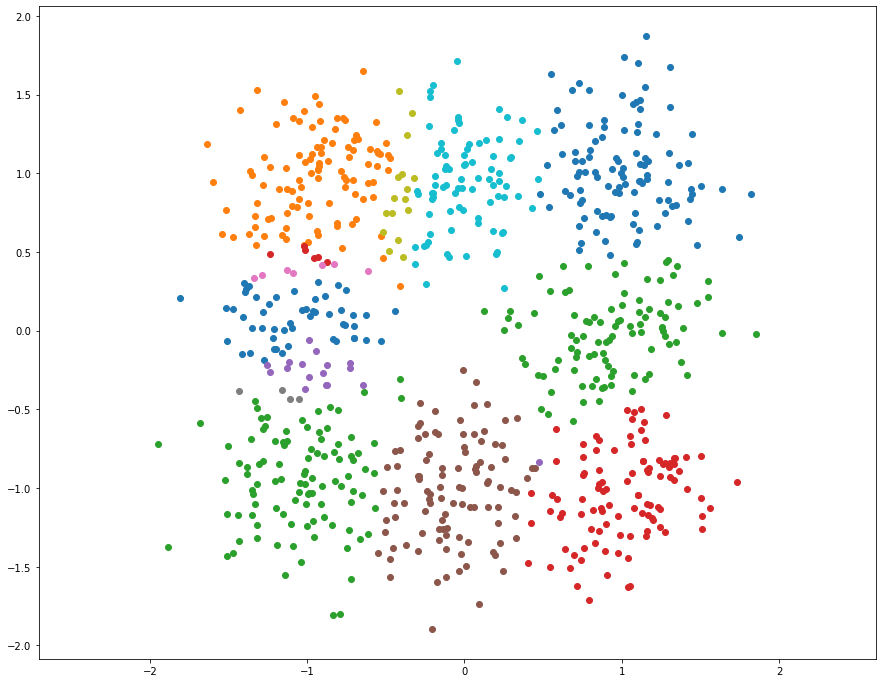

In [86]:
start = time()
mean_shifter = ms(radius=0.5)
_, assignments = mean_shifter.fit(X2)
end = time()

#assignments = np.array(assignments)
#print(assignments)

mean_shift_runtime = end - start
print("Mean-shift running time: %f seconds." % mean_shift_runtime)

for i in range(np.max(assignments)+1):
    cluster_i = X2[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])
plt.axis('equal')
plt.show()

### 4.4 Pros: robust to Outliers

Using mean-shift

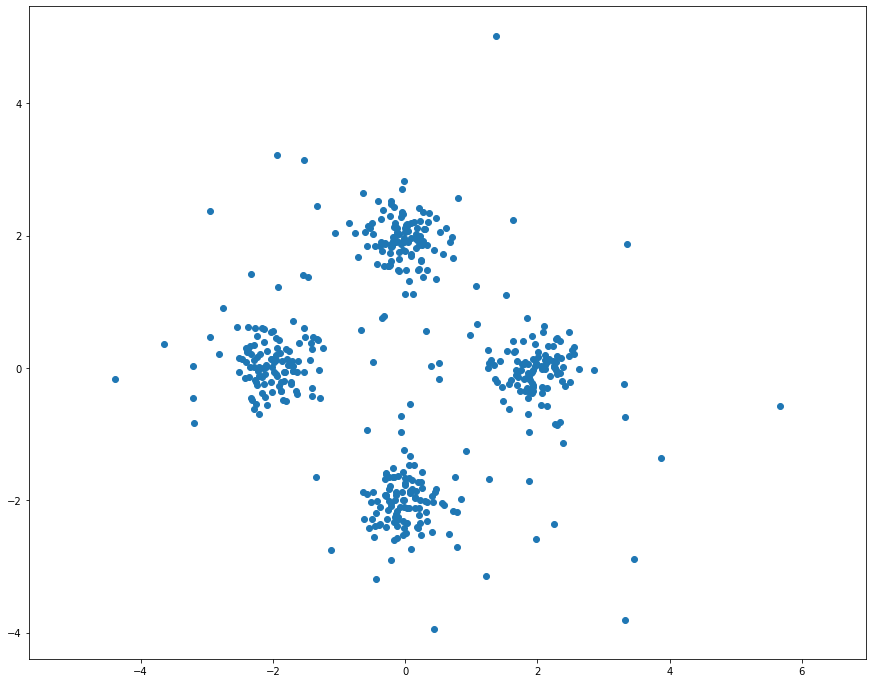

In [134]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-2, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 2]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [2, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -2]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Outliers
mean5 = [-2, 0]
cov5 = [[2, 0], [0, 2]]
X5 = np.random.multivariate_normal(mean5, cov5, 20)
mean6 = [0, 2]
cov6 = [[2, 0], [0, 2]]
X6 = np.random.multivariate_normal(mean6, cov6, 20)
mean7 = [2, 0]
cov7 = [[2, 0], [0, 2]]
X7 = np.random.multivariate_normal(mean7, cov7, 20)
mean8 = [0, -2]
cov8 = [[2, 0], [0, 2]]
X8 = np.random.multivariate_normal(mean8, cov8, 20)

# Merge two sets of data points
X_3 = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8))

# Plot data points
plt.scatter(X_3[:, 0], X_3[:, 1])
plt.axis('equal')
plt.show()

Mean-shift running time: 3.327219 seconds.


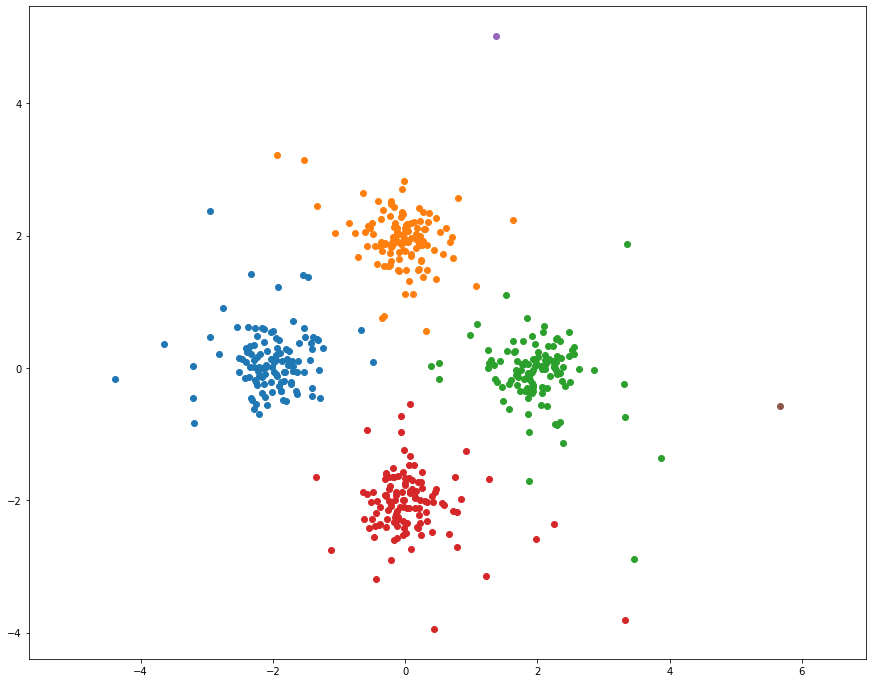

In [135]:
start = time()
mean_shifter = ms(radius=1.6)
_, assignments = mean_shifter.fit(X)
end = time()

#assignments = np.array(assignments)
#print(assignments)

mean_shift_runtime = end - start
print("Mean-shift running time: %f seconds." % mean_shift_runtime)

for i in range(np.max(assignments)+1):
    cluster_i = X_3[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])
plt.axis('equal')
plt.show()

Using k-mean

kmeans running time: 0.009647 seconds.
534.727201 times faster!


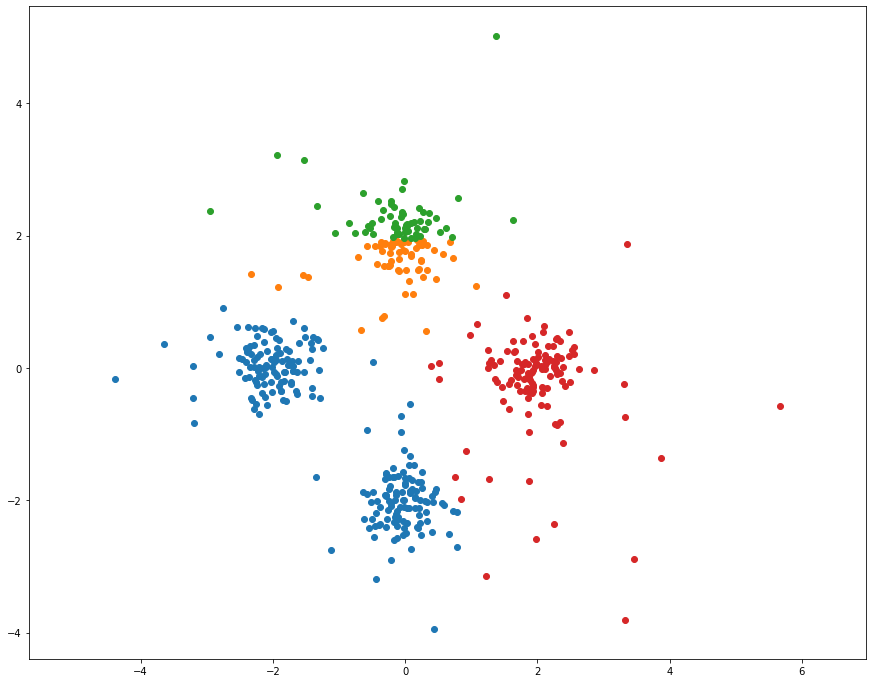

In [137]:
from segmentation import kmeans_fast

np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 4.5 Image Segmentation

(100, 200, 3)


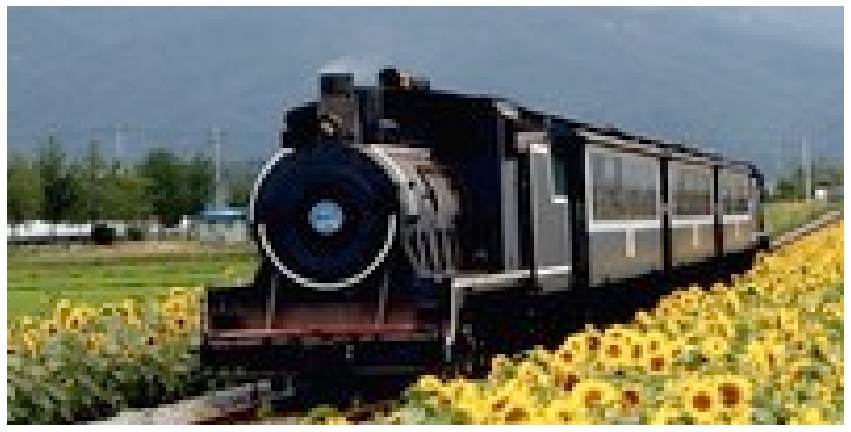

In [13]:
# Load and display image
img = io.imread('train.jpg')
img = img[100:200,250:450,:]
H, W, C = img.shape
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

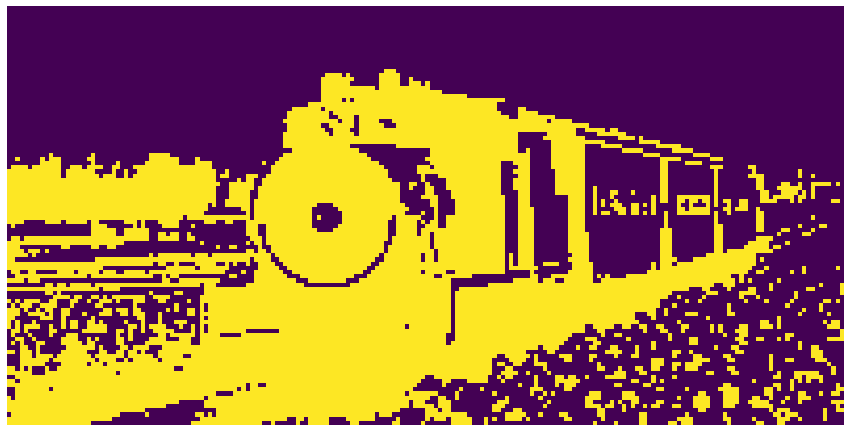

In [14]:
from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

clustering = MeanShift().fit(features)
assignments = clustering.labels_
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()